- A brief explanation for our attached files
    - Assignment3.ipynb
        - Instructions and visualization are given
    - data.pt
        - A subset of images from ImageNet validation set.
    - yourAnswer.py
        - A skelleton code for interpretations.
    - utils.py
        - A utility functions are stored. You don't need to care about this functions
    - module (directory)
        - This directory contains modules to implement LRP. Since implementing every module is not easy for beginner, we only skeletonize the linear.py file.

    - yourAnswer.py
    - linear.py


In [1]:
import torch
import torchvision

from utils import normalize
from utils import visualize_images, visualize_interpretations, resize

# 1. Predict and visualize

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.9MB/s]


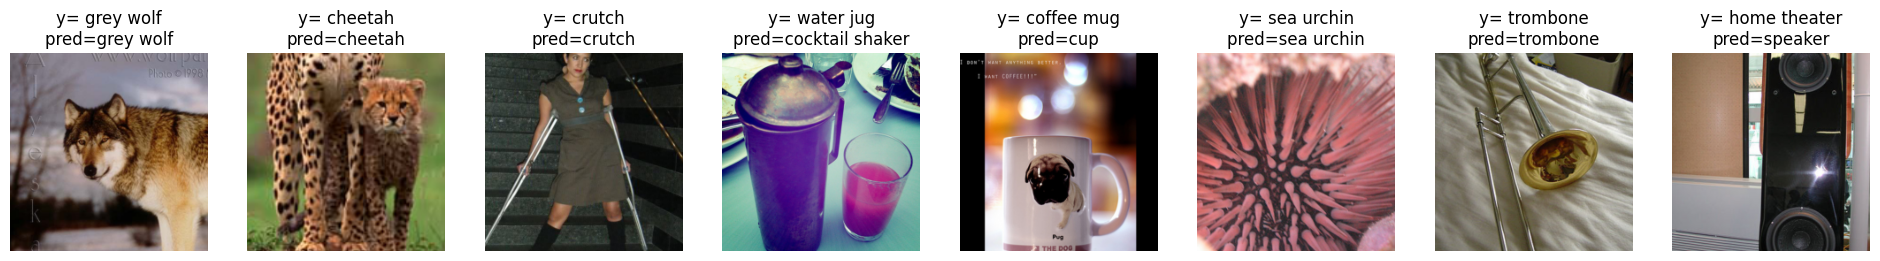

In [2]:
# load model
model = torchvision.models.vgg16(pretrained=True)

# load data and normalize
(x, y) = torch.load('data.pt') # x in [0, 1]
x = x[:8]
y = y[:8]
x_norm = normalize(x)
x_norm.requires_grad = True

# predict
pred = model(x_norm)
y_hat = torch.argmax(pred, dim=1)

# visualize
visualize_images(x, y, y_hat, row=1, col=8)

In [3]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 2. Interpretation

To interpret the behavior of model, we employ LRP, Grad-CAM, and the other four gradient based methods.

In [4]:
def grad_cam(model, x, y):

    target_layer_output = []
    def save_activation():
        def hook(model, input, output):
            target_layer_output.append(output)
        return hook

    layer, sub_layer = 'features', '28'
    hook_handler = model.__dict__['_modules'][layer][int(sub_layer)].register_forward_hook(save_activation())

    ################### your answer should be written in here ################
    y_pred = model(x) # 8 * 1000
    yc = y_pred[range(len(y)), y] # 8 * 1
    target_layer_grad = torch.autograd.grad(yc, target_layer_output[0], grad_outputs = torch.ones_like(yc))[0]
    weight = torch.nn.functional.adaptive_avg_pool2d(target_layer_grad, 1)

    # target_layer_output -> 8 * 512 * 14 * 14
    # after sum, 8 * 1 * 14 * 14
    h = torch.mul(target_layer_output[0], weight).sum(dim = 1, keepdim = True)
    # w = average grad -> torch.nn.functional.adaptive_avg_pool2d(input1, 1) ->
    # h = w * target_layer_output

    ################### your answer should be written in here ################
    hook_handler.remove()

    return h.detach().cpu()




In [5]:
# Grad-CAM

h_grad_cam = grad_cam(model, x_norm, y)

## LRP

The functions of LRP is defined in module directory. Since it is hard to implement such LRP rules for Convolution layer, we only make a blank in linear.py module. Please refer the lecture slide for the implementation of lrp.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/ai_expert/27_xai/XAI/code/
%ls

/content/drive/MyDrive/ai_expert/27_xai/XAI/code
data.pt  day3_xai.ipynb  module/  __pycache__/  utils.py


In [9]:
from module.model_VGG16 import vgg16
# LRP-composite

model = vgg16(pretrained=True)
model.eval()
pred = model(x_norm)
R = torch.eye(1000, device=x.device, dtype=x.dtype)[y] * pred
h_lrp = model.lrp(R, lrp_mode="composite")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


## Visualize your interpretation here.

To visualize the interpretation functions, we have to map $h \in \mathbb{R}^d$ into $\mathbb{R}^d -> \{0,1,...,255\}^d$ or $\mathbb{R}^d -> [0, 1]^d$. To achieve this, the frequently used technique on interpretation researches is define as follows,

$h \leftarrow (\frac{|h|}{max(|h|)}+1)/2$

We use 'sessmic' colormap.

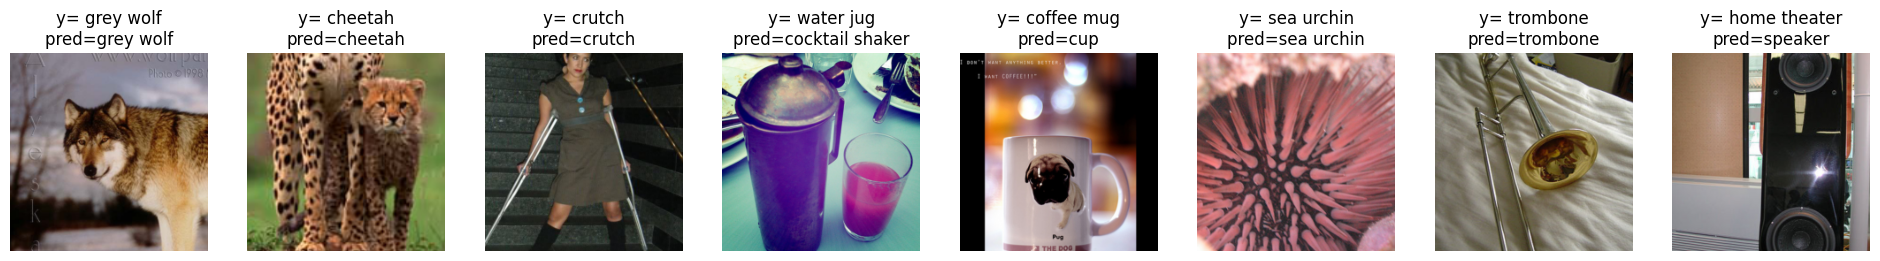

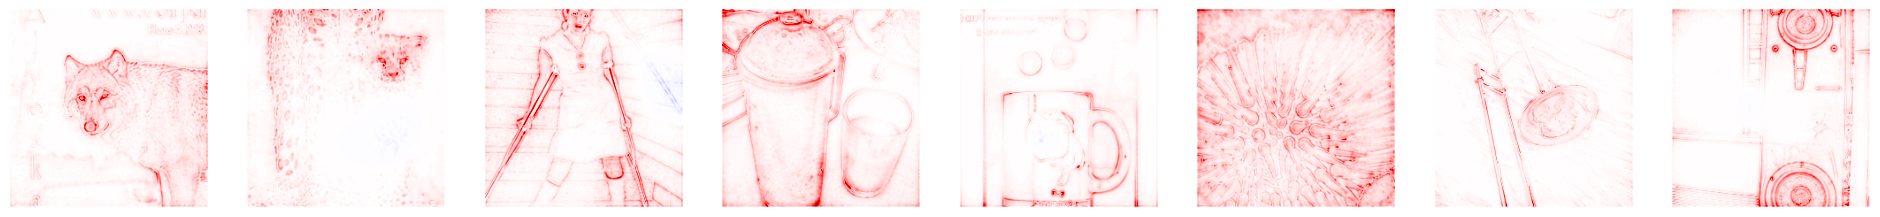

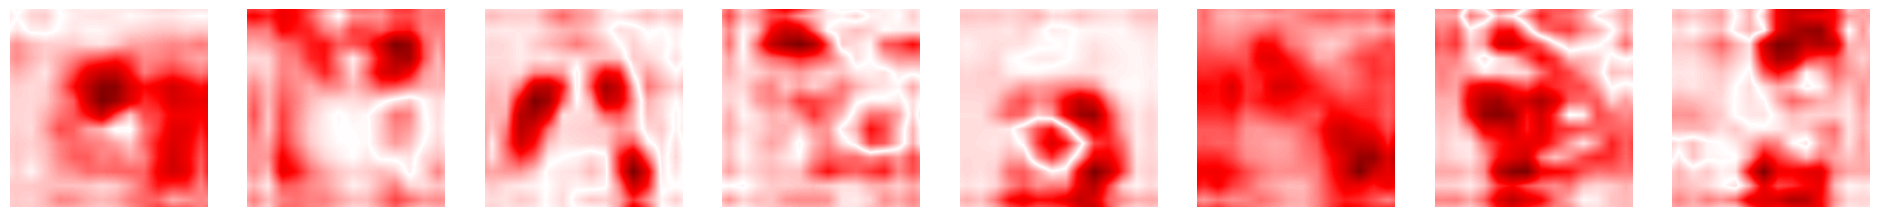

In [10]:
visualize_images(x, y, y_hat, row=1, col=8)
visualize_interpretations(h_lrp.detach(), row=1, col=8, absolute=False)
visualize_interpretations(resize(h_grad_cam, 224, 224), row=1, col=8, absolute=True)